In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import copy
import string

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [1686]:
url = '/Users/yunsu/desktop/python_ocr/2016.png'
url2 = '/Users/yunsu/desktop/python_ocr/2014.png'

In [1647]:
def pre_process(url):
    src = cv2.imread(url)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(gray)
    joints, mask, line_wit, v_size2, h_final, v_final = find_joints(url)
    one_line = make_points_list(joints=joints, line_wit=line_wit, v_size2=v_size2)
    points = align_points(one_line=one_line, joints=joints)
    box = make_box(points, joints, v_size2, line_wit)    
    show_box(box=box, mask=mask)
    c_points = give_conditions(points=points, mask=mask, v_size2=v_size2, line_wit=line_wit)
    is_st, is_bot, is_end, is_right = classify_points(c_points=c_points, joints=joints, v_size2=v_size2, 
                                                      line_wit=line_wit, mask=mask, points=points)
    st, end = cut_points(joints=joints, is_st=is_st, is_bot=is_bot, is_end=is_end, is_right=is_right)
    fix_st_0 = fix_st_vertical(h_final, st=st)
    fix_st_1 = fix_st_horizontal(v_final, st=st)
    st = fix_st(st, fix_st_0=fix_st_0, fix_st_1=fix_st_1)
    img_list = make_crack(ful_img=img, st=st, end=end)
    return img_list


def find_joints(url):
    #이미지를 읽는다.
    src = cv2.imread(url)
    # 이미지를 회색화한다.
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    # 이미지 전처리_ 잡티제거
    bw = cv2.adaptiveThreshold(~gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -5)
    horizontal = bw.copy()
    vertical = bw.copy()
    #v_size와 v_size2는 중요하다. v_size는 전체 이미지 높이의 1/20에 해당되는 길이의 수직선부터 테이블을 구성할 수 있다고 생각하는 것.
    #v_size2는 수평선과 수직선의 교차점을 찾을 때 확실히 해주기 위해 도와주는 추가적인 코드다.
    v_size = vertical.shape[0]//20
    v_size2 = max(1, vertical.shape[0]//100)
    v_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size))
    v_struct2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size2))
    v_sub = cv2.erode(vertical, v_struct, iterations=1)
    v_final_sub = cv2.dilate(v_sub, v_struct, iterations=1)
    v_final = cv2.dilate(v_final_sub, v_struct2, iterations=1)
    h_size = horizontal.shape[1]//20
    h_struct = cv2.getStructuringElement(cv2.MORPH_RECT,(h_size,1))
    h_struct2 = cv2.getStructuringElement(cv2.MORPH_RECT,(v_size2,1))
    h_sub = cv2.erode(horizontal, h_struct, iterations = 1)
    h_final_sub = cv2.dilate(h_sub, h_struct, iterations = 1)
    h_final = cv2.dilate(h_final_sub, h_struct2, iterations = 1)
    line_wit = check_line_wit(h_final)
    joints = cv2.bitwise_and(v_final, h_final)
    mask = h_final + v_final
    return joints, mask, line_wit, v_size2, h_final, v_final

def check_line_wit(h_final):
    h_final[h_final >= 200] = 255
    wit = 0
    wit_list = []
    for p in h_final[:, h_final.shape[1]//2]:
        if p == 255:
            wit += 1
        else: 
            wit_list.append(wit)
            wit = 0
    line_wit = max(wit_list)
    return line_wit



def make_points_list(line_wit, v_size2, joints):
    re_joints = joints.copy() 
    for i in range(joints.shape[0]):
        for j in range(joints.shape[1]):
            if re_joints[i][j] !=0:
                re_joints[max(0, i - line_wit * 2): min(i + line_wit * 2, joints.shape[0] - 1), 
                       max(0,j - line_wit * 2): min(j + line_wit * 2, joints.shape[1] - 1)] = 0
                re_joints[i][j] = 255
    one_line = []

    for i in range(joints.shape[0]):
        for j in range(joints.shape[1]):
            if re_joints[i][j] == 255:
                one_line.append((i,j))
    return one_line

def align_points(one_line, joints):
    points = {}
    tmp = []
    k = 0
    fst = one_line[0]
    for pos in one_line:
        plow = fst[0]
        # allow는 경험적 데이터로, 테이블이 비틀어졌을 때를 대비해 allow만큼 비틀린 테이블까지는 인식하겠다는 말이다. 
        allow = int(joints.shape[0] * 0.03)
        rng = range(max(0, plow - allow), min(joints.shape[0] - 1, plow + allow))
        if pos[0] in rng:
            tmp.append(pos)
        else:
            tmp = sorted(tmp, key=lambda x : x[1])
            k += 1
            points['line' + str(k)] = tmp
            tmp = []
            fst = pos
            tmp.append(pos)
    k += 1
    points['line' + str(k)] = tmp
    return points
    
def make_box(points, joints, v_size2, line_wit):
    # 점 주위에 박스처리 해주는 기능
    depth = max(3, v_size2 + line_wit)
    box = np.zeros_like(joints)
    for i in range(1, len(points) + 1):
        line = points['line' + str(i)]
        for idx, p in enumerate(line):
            box[max(0, p[0] - depth) , max(0, p[1] - depth) : min(joints.shape[1] - 1, p[1] + depth)] = 255
            box[max(0, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)] = 255
            box[min(joints.shape[0] - 1, p[0] + depth), 
                             max(0, p[1] - depth) : min(joints.shape[1] -1 ,p[1] + depth)] = 255
            box[min(joints.shape[0] - 1, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), 
                             min(joints.shape[1] -1 ,p[1] + depth)] = 255
    return box

def show_box(box, mask):
    boxed = box + mask
    cv2.imshow('boxed', boxed)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return None

def give_conditions(points, mask, v_size2, line_wit):
    # 좌표에 컨디션을 부과해주는 함수
    mask[mask > 240] = 255
    depth = max(3, v_size2 + line_wit)
    c_points = copy.deepcopy(points)
    for i in range(1, len(c_points) + 1):
        line = c_points['line' + str(i)]
        for idx, p in enumerate(line):
            tmp = ''
            c1 = 255 in mask[max(0, p[0] - depth) , max(0, p[1] - depth) : min(mask.shape[1] - 1, p[1] + depth)]
            c2 = 255 in mask[max(0, p[0] - depth) : min(mask.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)]
            c3 = 255 in mask[min(mask.shape[0] - 1, p[0] + depth), 
                             max(0, p[1] - depth) : min(mask.shape[1] -1 ,p[1] + depth)] 
            c4 = 255 in mask[min(mask.shape[0] - 1, p[0] - depth) : min(mask.shape[0] - 1, p[0] + depth), 
                             min(mask.shape[1] -1 ,p[1] + depth)]
            if c1:
                tmp += 'c1'
            if c2:
                tmp += 'c2'
            if c3:
                tmp += 'c3'
            if c4:
                tmp += 'c4'
            line[idx] = (p, tmp)
    return c_points

def classify_points(c_points, joints, v_size2, line_wit, mask, points):
# 좌표를 각각 시작점, 보조점, 끝점으로 분류해주는 기능.
# 좌표를 각각 시작점, 보조점, 끝점으로 분류해주는 기능.
    for depth_bound in range(2, 5):
        allow = int(joints.shape[1] * 0.02)
        is_st = []
        is_end = []
        is_right = []
        is_bot = []
        for i in range(1, len(c_points) + 1):
            line = c_points['line' + str(i)]
            for idx, p in enumerate(line):
                if 'c3c4' in p[1]: 
                    is_st.append(p[0])
                if 'c1c2' in p[1]:
                    is_end.append(p[0])
                if 'c2c3' in p[1]:
                    is_right.append(p[0])
                if 'c1' in p[1] and 'c4' in p[1]:
                    is_bot.append(p[0])
        if len(is_st) == len(is_right) == len(is_bot) == len(is_end):
            break
        else:
            print("시작점과 다른 점들의 수가 맞지 않습니다.")
            print("depth를 더 늘려 수정진행합니다.")
            # 점 주위에 박스처리 해주는 기능
            up_line_wit = line_wit * depth_bound
            box = make_box(points, joints, v_size2, up_line_wit)
            show_box(box, mask)
            
            # 좌표에 컨디션을 부과해주는 함수
            c_points = give_conditions(points, mask, v_size2, up_line_wit)
    return is_st, is_bot, is_end, is_right

    # 자를 좌표를 정해주는 기능
def cut_points(joints, is_st, is_bot, is_end, is_right):
    st = []
    end = []
    allow = int(joints.shape[1] * 0.02)
    # 스타트 다음에 나오는 right 는 무조건 직전 스타트와 사각형을 이룬다.
    for idx, p in enumerate(is_st):
        st.append(p)
        rgt = is_right[idx]
        for thing in is_bot:
            if thing[1] in range(p[1] - allow, p[1] + allow ):
                bot = thing
                is_bot.remove(thing)
                break
        for thing in is_end:
            if thing[0] in range(bot[0] - allow, bot[0] + allow ) and thing[1] in range(rgt[1] - allow, rgt[1] + allow):
                end.append(thing)
                is_end.remove(thing)
                break
    return st, end

def fix_st_horizontal(v_final, st):
    allow = 3
    certain = 50
    assume_wit = 15  
    v_final[v_final > 240] = 255
    fix_st_1 = []
    for start in st:
        for move in range(assume_wit):
            if 255 in v_final[max(0, start[0] + certain - allow): min(v_final.shape[0] - 1, start[0] + certain + allow), 
                       start[1] + assume_wit - move]:
                fix_st_1.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_1.append(0)
    return fix_st_1

# 각 테이블 윤곽선 두께가 다를 수 있기때문에 두께를 고려해서 시작점의 vertical 좌표에 더하거나 뺄 값을 계산한다.
# 인자는 v_final이 아니라 h_final이 들어간다는 점에 유의해야한다.
def fix_st_vertical(h_final, st):
    allow = 3
    certain = 20
    assume_wit = 15  
    h_final[h_final > 240] = 255
    fix_st_0 = []
    for start in st:
        for move in range(1, assume_wit):
            # 시작점이 좌상단에 있기 때문에 실제 테이블의 굵기가 아닌 옆 테이블의 굵기를 측정할 수 있다. width에만 해당된다. 따라서 certain 값을 더해 
            # 자신 테이블의 윗 수평선 굵기를 잰다.
            # start[0] 좌표에서 assume_wit만큼 내려오면 흰 여백에 위치한다. 이 곳에서 위쪽으로 조금씩(move)하면서 테이블 검은 선과 만날 때 
            # start[0] 에서부터의 검은선까지의 거리를 계산한다. 이렇게하지 않으면 테이블 선 내부에 흰 공간이 있는 경우 오류를 내게 되서 이런 코드를
            # 짜게 되었다. 
            # certain은 오른쪽으로 이동하는 값인데, 오른쪽으로 이동하지 않으면 옆에 테이블 윤곽선의 두께에 영향을 받기 때문에, 영향을 최소화하기 위해
            # 확실히 옆테이블과 떨어진 위치에서 떨어져(certain) 계산한다.
            # allow는 예측하지못한 상황에서 대비하기 위해 작성했는데, 상황에 따라 없어야 하는 코드가 될 수 있다.!
            if 255 in h_final[start[0] + assume_wit - move , 
                              max(0, start[1] + certain  - allow) : min(h_final.shape[1] - 1, start[1] + certain + allow )]:
                fix_st_0.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_0.append(0)
    return fix_st_0

def fix_st(st, fix_st_1, fix_st_0):
    for idx, add in enumerate(zip(fix_st_0, fix_st_1)):
        tmp = st[idx][0] + add[0], st[idx][1] + add[1]
        st[idx] = tmp
    return st

def make_crack(ful_img, st, end):
    img_list = []

    for i in range(len(st)):
        # +1을 해주는 이유, img는 시작값이 0이아닌 1이기 때문에 배열의 모양과 맞추려면 +1이 맞음.
        tmp = ful_img.crop((st[i][1] + 1, st[i][0] + 1, end[i][1] - 1, end[i][0] - 1))
        # 글자가 작은 경우 잘못 읽는 경우가 생겨, 시간 비용이 들더라도 정확도를 올려주기 위해 이미지 사이즈를 2배로 늘린다.
        size = (tmp.size[0]*2, tmp.size[1] * 2)
        tmp = tmp.resize(size)
        img_list.append(tmp)
    return img_list


In [1753]:
src = cv2.imread(url2)

In [1754]:
src.shape

(1072, 1692, 3)

In [1755]:
# src = cv2.resize(src, (800, 800))

In [1756]:
cv2.imshow('src', src)
cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [1757]:
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

In [1758]:
cv2.imshow('gray', gray)
cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [1759]:
ret,thresh = cv2.threshold(gray,100 ,255,cv2.THRESH_BINARY_INV)


In [1760]:
cv2.imshow('thresh', thresh)
cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [1761]:
bw = cv2.adaptiveThreshold(~gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -5)

In [1762]:
cv2.imshow('bw', bw)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1763]:
horizontal = bw.copy()
vertical = bw.copy()

In [1764]:
v_size = vertical.shape[0]//20
v_size2 = max(1, vertical.shape[0]//100)
v_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size))
v_struct2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size2))
v_sub = cv2.erode(vertical, v_struct, iterations=1)
v_final_sub = cv2.dilate(v_sub, v_struct, iterations=1)
v_final = cv2.dilate(v_final_sub, v_struct2, iterations=1)

In [1765]:
cv2.imshow('vertical', v_final)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1766]:
h_size = horizontal.shape[1]//20
# h_size2 = max(1, horizontal.shape[1]//100)
h_struct = cv2.getStructuringElement(cv2.MORPH_RECT,(h_size,1))
h_struct2 = cv2.getStructuringElement(cv2.MORPH_RECT,(v_size2,1))
h_sub = cv2.erode(horizontal, h_struct, iterations = 1)
h_final_sub = cv2.dilate(h_sub, h_struct, iterations = 1)
h_final = cv2.dilate(h_final_sub, h_struct2, iterations = 1)


In [1767]:
h_final[h_final >= 200] = 255
wit = 0
wit_list = []
random = rand
for p in h_final[:, h_final.shape[1]//2]:
    if p == 255:
        wit += 1
    else: 
        wit_list.append(wit)
        wit = 0
line_wit = max(wit_list)
line_wit



6

In [1768]:
cv2.imshow('horizontal', h_final)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1769]:
mask = h_final + v_final

In [1770]:
cv2.imshow('mask', mask)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1771]:
joints = cv2.bitwise_and(v_final, h_final)

In [1772]:
cv2.imshow('joint', joints)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1773]:
re_joints = joints.copy() 

for i in range(joints.shape[0]):
    for j in range(joints.shape[1]):
        if re_joints[i][j] !=0:
            re_joints[max(0, i - line_wit * 2): min(i + line_wit * 2, joints.shape[0] - 1), 
                   max(0,j - line_wit * 2): min(j + line_wit * 2, joints.shape[1] - 1)] = 0
            re_joints[i][j] = 255
points = {}
one_line = []
tmp = []
k = 0
            
for i in range(joints.shape[0]):
    for j in range(joints.shape[1]):
        if re_joints[i][j] == 255:
            one_line.append((i,j))
            
            
fst = one_line[0]
for pos in one_line:
    plow = fst[0]
    allow = int(joints.shape[0] * 0.03)
    rng = range(max(0, plow - allow), min(joints.shape[0] - 1, plow + allow))
    if pos[0] in rng:
        tmp.append(pos)
    else:
        tmp = sorted(tmp, key=lambda x : x[1])
        k += 1
        points['line' + str(k)] = tmp
        tmp = []
        fst = pos
        tmp.append(pos)
k += 1
points['line' + str(k)] = tmp



In [1774]:
points

{'line1': [(153, 117), (153, 401), (152, 904), (152, 1601)],
 'line10': [(703, 781), (703, 935), (703, 1068), (703, 1198)],
 'line11': [(739, 1198), (739, 1601)],
 'line12': [(807, 1198), (807, 1601)],
 'line13': [(869, 117),
  (869, 681),
  (869, 781),
  (869, 1141),
  (869, 1198),
  (869, 1601)],
 'line14': [(930, 117), (930, 681), (930, 1141), (930, 1601)],
 'line15': [(991, 117), (991, 681), (991, 1141), (991, 1601)],
 'line2': [(220, 117),
  (216, 401),
  (216, 782),
  (216, 899),
  (220, 1198),
  (220, 1597)],
 'line3': [(285, 117), (281, 781), (281, 1198), (281, 1597)],
 'line4': [(347, 781), (347, 1198), (347, 1601)],
 'line5': [(408, 781), (408, 1198), (408, 1601)],
 'line6': [(470, 117), (470, 781), (470, 1194), (470, 1601)],
 'line7': [(535, 117), (531, 781), (531, 1194), (535, 1601)],
 'line8': [(602, 781), (602, 935), (602, 1068), (602, 1198), (602, 1601)],
 'line9': [(670, 1198), (670, 1601)]}

In [1775]:
cv2.imshow('re_joints', re_joints)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1776]:
# 점 주위에 박스처리 해주는 기능
depth = max(3, v_size2 + line_wit)
box = np.zeros_like(mask)
for i in range(1, len(points) + 1):
    line = points['line' + str(i)]
    for idx, p in enumerate(line):
        box[max(0, p[0] - depth) , max(0, p[1] - depth) : min(joints.shape[1] - 1, p[1] + depth)] = 255
        box[max(0, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)] = 255
        box[min(joints.shape[0] - 1, p[0] + depth), 
                         max(0, p[1] - depth) : min(joints.shape[1] -1 ,p[1] + depth)] = 255
        box[min(joints.shape[0] - 1, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), 
                         min(joints.shape[1] -1 ,p[1] + depth)] = 255


In [1777]:
boxed = box + mask

In [1778]:
cv2.imshow('boxed', boxed)
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [1779]:
# 좌표에 컨디션을 부과해주는 함수
mask[mask > 240] = 255
depth = max(3, v_size2 + line_wit)
c_points = copy.deepcopy(points)
for i in range(1, len(c_points) + 1):
    line = c_points['line' + str(i)]
    for idx, p in enumerate(line):
        tmp = ''
        c1 = 255 in mask[max(0, p[0] - depth) , max(0, p[1] - depth) : min(joints.shape[1] - 1, p[1] + depth)]
        c2 = 255 in mask[max(0, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)]
        c3 = 255 in mask[min(joints.shape[0] - 1, p[0] + depth), 
                         max(0, p[1] - depth) : min(joints.shape[1] -1 ,p[1] + depth)] 
        c4 = 255 in mask[min(joints.shape[0] - 1, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), 
                         min(joints.shape[1] -1 ,p[1] + depth)]
        if c1:
            tmp += 'c1'
        if c2:
            tmp += 'c2'
        if c3:
            tmp += 'c3'
        if c4:
            tmp += 'c4'
        line[idx] = (p, tmp)


In [1780]:
# 좌표를 각각 시작점, 보조점, 끝점으로 분류해주는 기능.
for depth_bound in range(2, 5):
    allow = int(joints.shape[1] * 0.02)
    is_st = []
    is_end = []
    is_right = []
    is_bot = []
    for i in range(1, len(c_points) + 1):
        line = c_points['line' + str(i)]
        for idx, p in enumerate(line):
            if 'c3c4' in p[1]: 
                is_st.append(p[0])
            if 'c1c2' in p[1]:
                is_end.append(p[0])
            if 'c2c3' in p[1]:
                is_right.append(p[0])
            if 'c1' in p[1] and 'c4' in p[1]:
                is_bot.append(p[0])
    if len(is_st) == len(is_right) == len(is_bot) == len(is_end):
        break
    else:
        print("시작점과 다른 점들의 수가 맞지 않습니다.")
        print("depth를 더 늘려 수정진행합니다.")
        # 점 주위에 박스처리 해주는 기능
        depth = max(3, v_size2 + line_wit * depth_bound)
        box = np.zeros_like(mask)
        for i in range(1, len(points) + 1):
            line = points['line' + str(i)]
            for idx, p in enumerate(line):
                box[max(0, p[0] - depth) , max(0, p[1] - depth) : min(joints.shape[1] - 1, p[1] + depth)] = 255
                box[max(0, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)] = 255
                box[min(joints.shape[0] - 1, p[0] + depth), 
                                 max(0, p[1] - depth) : min(joints.shape[1] -1 ,p[1] + depth)] = 255
                box[min(joints.shape[0] - 1, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), 
                                 min(joints.shape[1] -1 ,p[1] + depth)] = 255
        boxed = box + mask
        cv2.imshow('boxed', boxed)
        cv2.waitKey(0)
        cv2.destroyAllWindows() 
        cv2.waitKey(1)
        
        # 좌표에 컨디션을 부과해주는 함수
        mask[mask > 240] = 255
        depth = max(3, v_size2 + line_wit * depth_bound)
        c_points = copy.deepcopy(points)
        for i in range(1, len(c_points) + 1):
            line = c_points['line' + str(i)]
            for idx, p in enumerate(line):
                tmp = ''
                c1 = 255 in mask[max(0, p[0] - depth) , max(0, p[1] - depth) : min(joints.shape[1] - 1, p[1] + depth)]
                c2 = 255 in mask[max(0, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), max(0, p[1] - depth)]
                c3 = 255 in mask[min(joints.shape[0] - 1, p[0] + depth), 
                                 max(0, p[1] - depth) : min(joints.shape[1] -1 ,p[1] + depth)] 
                c4 = 255 in mask[min(joints.shape[0] - 1, p[0] - depth) : min(joints.shape[0] - 1, p[0] + depth), 
                                 min(joints.shape[1] -1 ,p[1] + depth)]
                if c1:
                    tmp += 'c1'
                if c2:
                    tmp += 'c2'
                if c3:
                    tmp += 'c3'
                if c4:
                    tmp += 'c4'
                line[idx] = (p, tmp)


In [1781]:
# 자를 좌표를 정해주는 기능
st = []
end = []
allow = int(joints.shape[1] * 0.02)
# 스타트 다음에 나오는 right 는 무조건 직전 스타트와 사각형을 이룬다.
for idx, p in enumerate(is_st):
    st.append(p)
    rgt = is_right[idx]
    for thing in is_bot:
        if thing[1] in range(p[1] - allow, p[1] + allow ):
            bot = thing
            is_bot.remove(thing)
            break
    for thing in is_end:
        if thing[0] in range(bot[0] - allow, bot[0] + allow ) and thing[1] in range(rgt[1] - allow, rgt[1] + allow):
            end.append(thing)
            is_end.remove(thing)
            break
print(st)
print(end)
        

[(153, 117), (153, 401), (152, 904), (220, 117), (216, 782), (220, 1198), (285, 117), (281, 781), (281, 1198), (347, 781), (347, 1198), (408, 781), (408, 1198), (470, 117), (470, 781), (470, 1194), (535, 117), (531, 781), (531, 1194), (602, 781), (602, 935), (602, 1068), (602, 1198), (670, 1198), (703, 781), (739, 1198), (807, 1198), (869, 117), (869, 681), (869, 1141), (930, 117), (930, 681), (930, 1141)]
[(216, 401), (216, 899), (220, 1597), (281, 781), (281, 1198), (281, 1597), (470, 781), (347, 1198), (347, 1601), (408, 1198), (408, 1601), (470, 1194), (470, 1601), (531, 781), (531, 1194), (535, 1601), (869, 781), (602, 1198), (602, 1601), (703, 935), (703, 1068), (703, 1198), (670, 1601), (739, 1601), (869, 1198), (807, 1601), (869, 1601), (930, 681), (930, 1141), (930, 1601), (991, 681), (991, 1141), (991, 1601)]


In [1782]:
def fix_st_horizontal(v_final):
    allow = 3
    certain = 50
    assume_wit = 15  
    v_final[v_final > 240] = 255
    fix_st_1 = []
    for start in st:
        for move in range(assume_wit):
            if 255 in v_final[max(0, start[0] + certain - allow): min(v_final.shape[0] - 1, start[0] + certain + allow), 
                       start[1] + assume_wit - move]:
                fix_st_1.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_1.append(0)
    return fix_st_1

# 각 테이블 윤곽선 두께가 다를 수 있기때문에 두께를 고려해서 시작점의 vertical 좌표에 더하거나 뺄 값을 계산한다.
# 인자는 v_final이 아니라 h_final이 들어간다는 점에 유의해야한다.



def fix_st_vertical(h_final):
    allow = 3
    certain = 20
    assume_wit = 15  
    h_final[h_final > 240] = 255
    fix_st_0 = []
    for start in st:
        for move in range(1, assume_wit):
            # 시작점이 좌상단에 있기 때문에 실제 테이블의 굵기가 아닌 옆 테이블의 굵기를 측정할 수 있다. width에만 해당된다. 따라서 certain 값을 더해 
            # 자신 테이블의 윗 수평선 굵기를 잰다.
            # start[0] 좌표에서 assume_wit만큼 내려오면 흰 여백에 위치한다. 이 곳에서 위쪽으로 조금씩(move)하면서 테이블 검은 선과 만날 때 
            # start[0] 에서부터의 검은선까지의 거리를 계산한다. 이렇게하지 않으면 테이블 선 내부에 흰 공간이 있는 경우 오류를 내게 되서 이런 코드를
            # 짜게 되었다. 
            # certain은 오른쪽으로 이동하는 값인데, 오른쪽으로 이동하지 않으면 옆에 테이블 윤곽선의 두께에 영향을 받기 때문에, 영향을 최소화하기 위해
            # 확실히 옆테이블과 떨어진 위치에서 떨어져(certain) 계산한다.
            # allow는 예측하지못한 상황에서 대비하기 위해 작성했는데, 상황에 따라 없어야 하는 코드가 될 수 있다.!
            if 255 in h_final[start[0] + assume_wit - move , 
                              max(0, start[1] + certain  - allow) : min(h_final.shape[1] - 1, start[1] + certain + allow )]:
                fix_st_0.append(assume_wit - move + 1)
                break
            if move == assume_wit - 1:
                fix_st_0.append(0)
    return fix_st_0

def fix_st(st, fix_st_1, fix_st_0):
    for idx, add in enumerate(zip(fix_st_0, fix_st_1)):
        tmp = st[idx][0] + add[0], st[idx][1] + add[1]
        st[idx] = tmp
    return st

In [1783]:
allow = 3
certain = 20
assume_wit = 15  
v_final[v_final > 240] = 255
fix_st_1 = []
for start in st:
    for move in range(assume_wit):
        if 255 in v_final[max(0, start[0] + certain - allow): min(v_final.shape[0] - 1, start[0] + certain + allow), 
                   start[1] + assume_wit - move]:
            fix_st_1.append(assume_wit - move + 1)
            break
        if move == assume_wit - 1:
            fix_st_1.append(0)
fix_st_1

[2,
 6,
 0,
 2,
 6,
 4,
 3,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 7,
 6,
 3,
 3,
 6,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3]

In [1784]:
allow = 3
certain = 20
line_allow = 15  
h_final[h_final > 240] = 255
fix_st_0 = []
for start in st:
    for wit in range(1, line_allow):
        # 시작점이 좌상단에 있기 때문에 실제 테이블의 굵기가 아닌 옆 테이블의 굵기를 측정할 수 있다. width에만 해당된다. 따라서 certain 값을 더해 
        # 자신 테이블의 윗 수평선 굵기를 잰다.
        if 255 in h_final[start[0] + line_allow - wit , 
                          max(0, start[1] + certain  - allow) : min(h_final.shape[1] - 1, start[1] + certain + allow )]:
            fix_st_0.append(line_allow - wit + 1)
            break
        if wit == line_allow - 1:
            fix_st_0.append(0)
fix_st_0



[2,
 6,
 3,
 2,
 10,
 6,
 3,
 6,
 6,
 2,
 2,
 3,
 3,
 2,
 6,
 2,
 2,
 6,
 6,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [1785]:
for idx, add in enumerate(zip(fix_st_0, fix_st_1)):
    tmp = st[idx][0] + add[0], st[idx][1] + add[1]
    st[idx] = tmp

In [1795]:
img = Image.fromarray(gray)

In [1796]:
img_list = make_crack(ful_img=img, st=st, end=end)

In [1797]:
page = []
for img in img_list:
    page.append(pytesseract.image_to_string(img))

In [1794]:
def make_crack(ful_img, st, end):
    img_list = []

    for i in range(len(st)):
        # +1을 해주는 이유, img는 시작값이 0이아닌 1이기 때문에 배열의 모양과 맞추려면 +1이 맞음.
        tmp = ful_img.crop((st[i][1] + 1, st[i][0] + 1, end[i][1] - 1, end[i][0] - 1))
        # 글자가 작은 경우 잘못 읽는 경우가 생겨, 시간 비용이 들더라도 정확도를 올려주기 위해 이미지 사이즈를 2배로 늘린다.
        size = (int(tmp.size[0]*1.5), int(tmp.size[1] * 1.5))
        tmp = tmp.resize(size)
        img_list.append(tmp)
    return img_list


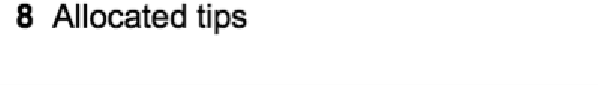

In [1800]:
img_list[12]

In [1748]:
pytesseract.image_to_string(img_list[0])

'a. Employee’s Social Security Number'

In [1798]:
page

['',
 "a Employee's social security number\n\n308-27—4383",
 'OMB No. 1545-0008',
 'b Employer identiﬁcation number\n\n13-5565207',
 '1 Wages. tips. other compensation\n\n76579.31',
 '2 Federal income tax withheld\n\n14438.62',
 "c Employer's name, address, and ZIP code\n\nKPMG LLP #2381212\n717 N. Harwood Street Suite 3100\nDallas, TX 75201-6585",
 '3 Social security wages\n\n76579.31',
 '4 Social security tax withheld\n\n4747.92',
 '5 Medicare wages and tips\n\n76579.31',
 '6 Medicare tax withheld\n1 1 10.40',
 '7 Social security tips',
 'B Allocated tips',
 'd Control number',
 '',
 '1D Dependent care beneﬁts',
 "e Employee's ﬁrst name and initial\n\nBOSEOK IN\n\n255 S Grand Ave Apt 610\nLos Angeles, CA 90012\n\nf Employee‘s address and ZIP code\n\nLast name\n\nSuﬁ.",
 '11 Nonqualiﬁed plans',
 '12a See instructions for box 12\n\nDD l 4583.52',
 '13 Statutory\nemployee',
 'Retirement\nplan\n\nX',
 'Third-party\nsick pay',
 '12b',
 '12c',
 '14 Other\nCASDI 765.79',
 '12d',
 '',
 '15 S

In [996]:
# page 만들기.
page_ = "+".join(page)
pre_alphabet = None

for idx, alphabet in enumerate(page_):
    if alphabet in ['o', 'O'] and pre_alphabet in list('0123456789'):
        page_ = page_[:idx] + '0' +page_[idx + 1:]
    elif alphabet == '0' and pre_alphabet in string.ascii_letters:
        page_ = page_[:idx] + 'o' +page_[idx + 1:]
    
#     if alphabet == 'ﬁ':
#         page_ = page_[:idx] +'fi' + page_[idx + 1 :]

    pre_alphabet = alphabet
page = page_.split("+")

In [997]:
# 13번 처리
for idx, phrase in page:
    if 'statutory employee' in phrase.lower():
        print('statutory employee')
    if 'statutory\nemployee' in phrase.lower():
        print('statutory\nemployee')

statutory
employee


In [995]:
page

['',
 "a Employee's social security number\n\n308-27-4383",
 'OMB No. 1545-0008',
 'b Employer identiﬁcation number\n\n13-5565207',
 '1 Wages, tips, other compensation\n\n76579.31',
 '2 Federal income tax withheld\n\n14438.62',
 "c Employer's name. address. and ZIP code\n\nKPMG LLP #2381212\n717 N. Harwood Street Suite 3100\nDallas, TX 75201-6585",
 '3 Social security wages\n\n76579.31',
 '4 Social security tax withheld\n\n4747.92',
 '5 Medicare wages and tips\n\n76579.31',
 '6 Medicare tax withheld\n1 1 10.40',
 '7 Social security tips',
 '8 Allocated tips',
 'd Control number',
 '',
 '10 Dependent care beneﬁts',
 'e Employee‘s ﬁrst name and initial Last name Sufi.\n\nBOSEOK IN\n\n255 S Grand Ave Apt 610\nLos Angeles, CA 90012\n\nf Employee‘s address and ZIP code',
 '11 Nonqualiﬁed plans',
 '12a See instructions for box 12\n\nDD 4583.52',
 '13 Statutory\nemployee',
 'Retirement\nplan\n\nX',
 'Third-party\nsick pay',
 '12b',
 '12c',
 '14 Other\nCASDI 765.79',
 '12d',
 '',
 '15 State Em

In [288]:
#해결해야 하는 점들.
1. 숫자의 소수점에서 띄어쓰기를 좌우로 한번씩 하는데, courier 글씨체의 특성상 자간이 커서 그렇다. 소수점 좌우로 띄어쓰기 삭제해주기. 
(24267 . 78)
(2 3 6 6 7 . 7 8)
(1 4 6 7 . 4 0)

# 2. ZIP 코드나 사람 이름에서 숫자 0과 대문자 O를 혼동하지 않도록, 1순위는 테서락트를 Arial, Courier 글씨체를 우선으로 판단하도록 학습시킬수 있는지,
#    2순위로는 사람이름이나 ZIP코드를 잡아주는 코드 추가하기.

3. 단어 사전화 작업.
4. \n 처리를 어떻게 해 줄 것인가.(\n은 띄어쓰기로 수정.)
5. 연속된 숫자에서는 O알파뱃이 아닌 숫자로 처리하도록 명령.
6. 13번의 체크박스 처리.
7. 시간 줄이기.
8. fi 와 ﬁ가 차이가 있다는 거 인지하기

SyntaxError: invalid syntax (<ipython-input-288-0ffebfc87ad0>, line 2)

In [673]:
# 당분간 필요없는 코드
# for idx, line in enumerate(page):
#     tmp = list(line)
#     while(1):
#         if '\n' in tmp:
#             tmp.remove('\n')
#             cond = '\n' in tmp
#         else:
#             break

#     page[idx] = ''.join(tmp)

In [49]:
pytesseract.image_to_string(Image.open(url9))

"3 Iy R I III hlrd-palty\nD e“ e ent D .\nStaIIItuto I: P'all s Ck pay"

In [721]:
w2_dic = {}
d_result = result.copy()

for idx, line in enumerate(d_result):
    if line == '':
        continue
    key = line[:2] if '.' not in line[1] and ' ' not in line[1] else line[0]
    data = line.split("\n")[0]
    w2_dic[key] = data
w2_dic['11'] = '11 Nonqualified plans'

In [722]:
w2_dic

{'1': '1 wages, tips and other',
 '10': '10 dependent care benefits',
 '11': '11 Nonqualified plans',
 '12': '12 see instructions for box 12',
 '14': '14 see instructions for box 14',
 '15': '15 state',
 '16': '16 state wages,',
 '17': '17 state income',
 '18': '18 local wages, tips and',
 '19': '19 local income',
 '2': '2 federal income tax withheld',
 '20': '20 locality',
 '3': '3 social security wages',
 '4': '4 social security tax withheld',
 '5': '5 medicare wages and tips',
 '6': '6 medicare tax withheld',
 '7': '7 social security tips',
 '8': '8 allocated tips',
 'Em': 'employer’s state id number',
 'OM': 'omb no. 1545-0008 this information is being furnished to the internet revenue service. if you are required to ﬁle',
 'Re': 'retirement plan: yes',
 'St': 'statutory employee: no',
 'Th': 'third-party sick pay: no',
 'a': 'a. employee’s social security number',
 'b': 'b. employer‘s identification number',
 'c': 'c. employer‘s name, address, and zip code',
 'd': 'd. control numb

In [127]:
'\n' in 'to\nreport'

True

In [170]:
c_result = result.copy()
c_result = "+".join(c_result)
c_result = c_result.split("\n")
c_result = " ".join(c_result)
c_result = c_result.split("+")

In [607]:
# w2_list_ = [] 
# for line in c_result:
#     w2_list_.append(line.split(" "))

In [601]:
sorted(w2_list, key=lambda t : t[0])

[['1', 'wages,', 'tips', 'compensation'],
 ['10', 'dependent', 'care', 'benefits'],
 ['11', 'nonqualified', 'plans'],
 ['12', 'see', 'instructions', 'for', 'box', '12'],
 ['14', 'see', 'instructions', 'for', 'box', '14'],
 ['15', 'state'],
 ['16', 'state', 'wages,', 'tips', 'and', 'etc'],
 ['17', 'state', 'income', 'tax'],
 ['18', 'local', 'wages,', 'tips', 'and', 'etc'],
 ['19', 'local', 'income', 'tax'],
 ['2', 'federal', 'income', 'tax'],
 ['20', 'locality', 'name'],
 ['3', 'social', 'security', 'wages'],
 ['4', 'social', 'security', 'tax'],
 ['5', 'medicare', 'wages', 'tips'],
 ['6', 'medicare', 'tax'],
 ['7', 'social', 'security', 'tips'],
 ['8', 'allocated', 'tips'],
 ['a', 'employee', 'social', 'security', 'number'],
 ['b', 'employer', 'identification'],
 ['c', 'employer', 'name,', 'address,', 'and', 'zip'],
 ['d', 'control', 'number'],
 ['e', 'employee', 'name,', 'address,', 'and', 'zip'],
 ['employer', 'state', 'id', 'number'],
 ['omb', 'no'],
 ['retirement', 'plan'],
 ['statu

In [600]:
w2_list.remove(['20', 'locality', 'name'])

In [465]:
'‘' in 'employer‘s'

True

In [466]:
for idx, line in enumerate(w2_list):
    for wdx, word in enumerate(line):
        if '‘' in word:
            w2_list[idx][wdx] = word[:-2]

In [566]:
#햇갈리기 쉬운 것은 두번 확인 -- Employee zip code 와 Employer zip code는 한자차이지만 매우 중요.
# 

In [676]:
a = '1 2 3'

In [678]:
b = list(a)

In [707]:
a = '1 1 10.40'

In [709]:
' ' in list(a)

True

In [712]:
tmp = list(a)
while ' ' in tmp:
    tmp.remove(' ')
"".join(tmp)

'1110.40'

In [720]:
#text와 w2 사전 데이터 일치시키기.
for text in page:
    for idx, dic in enumerate(w2_list):
        header = dic[0] if len(dic[0]) ==2 else dic[0] + ' '
        #앞에 두자리를 보고 결정하기.
        text_header = text[:2]
        if header in text_header:
            data = text.split("\n")[1:]
            # 데이터 정리 작업. data 는 리스트
            # ''은 '\n'인데 두번 엔터를 눌러 입력하면 ''이 생긴다. 이 것을 삭제.
            if '' in data:
                while('' in data):
                    data.remove('')
            for idx, date in enumerate(data): 
                # 예외처리
                if 'Employee' in date:
                    data.remove(data[idx])
# 빈칸을 없애주면 빈칸이 필요한 (DD 3583.42 )에도 없어진다. 다시 생각해보니 디비에 넣을 떄 숫자만 처리해주면 될 것가타.
#             for idx, date in enumerate(data):
#                 if ' ' in date:
#                     tmp = list(date)
#                     while(' ' in tmp):
#                         tmp.remove(' ')
#                     data[idx] = "".join(tmp)
#             print(w2_list[idx], data)
            key = header if ' ' not in header else header[0]
            print(w2_dic[key], data)

# 13번 처리.

a. Employee’s Social Security Number ['308-27-4383']
b. Employer‘s Identification Number ['13-5565207']
1 Wages, Tips and other ['76579.31']
2 Federal Income Tax withheld ['14438.62']
c. Employer‘s Name, Address, and ZIP Code ['KPMG LLP #2381212', '717 N. Harwood Street Suite 3100', 'Dallas, TX 75201-6585']
3 Social Security Wages ['76579.31']
4 Social Security Tax withheld ['4747.92']
5 Medicare Wages and Tips ['76579.31']
6 Medicare Tax withheld ['1 1 10.40']
7 Social Security Tips []
8 Allocated Tips []
d. Control Number []
10 Dependent Care Benefits []
e. Employee’s Name, Address, and ZIP Code ['BOSEOK IN', '255 S Grand Ave Apt 610', 'Los Angeles, CA 90012']
11 Nonqualified plans []
12 See Instructions for box 12 ['DD 4583.52']
12 See Instructions for box 12 []
12 See Instructions for box 12 []
14 See Instructions for box 14 ['CASDI 765.79']
12 See Instructions for box 12 []
15 State ['CA | 073-3480—8']
16 State Wages, ['76579.31']
17 State Income ['4753.27']
20 Locality []
18 Loca

In [631]:
page

['',
 "a Employee's social security number\n\n308-27-4383",
 'OMB No. 1545-0008',
 'b Employer identiﬁcation number\n\n13-5565207',
 '1 Wages, tips, other compensation\n\n76579.31',
 '2 Federal income tax withheld\n\n14438.62',
 "c Employer's name. address. and ZIP code\n\nKPMG LLP #2381212\n717 N. Harwood Street Suite 3100\nDallas, TX 75201-6585",
 '3 Social security wages\n\n76579.31',
 '4 Social security tax withheld\n\n4747.92',
 '5 Medicare wages and tips\n\n76579.31',
 '6 Medicare tax withheld\n1 1 10.40',
 '7 Social security tips',
 '8 Allocated tips',
 'd Control number',
 '',
 '10 Dependent care beneﬁts',
 'e Employee‘s ﬁrst name and initial Last name Sufi.\n\nBOSEOK IN\n\n255 S Grand Ave Apt 610\nLos Angeles, CA 90012\n\nf Employee‘s address and ZIP code',
 '11 Nonqualiﬁed plans',
 '12a See instructions for box 12\n\nDD 4583.52',
 '13 Statutory\nemployee',
 'Retirement\nplan\n\nX',
 'Third-party\nsick pay',
 '12b',
 '12c',
 '14 Other\nCASDI 765.79',
 '12d',
 '',
 '15 State Em

In [668]:
dataset = w2_dic, w2_list, page

In [669]:
import pickle

In [670]:
with open('w2_list2.pk1', 'wb') as f:
    pickle.dump(dataset, f, -1)

In [174]:
line_words = {}
for idx, line in enumerate(c_result):
    line_words['line' + str(idx + 1)] = line


In [204]:
import collections

In [205]:
int('3')

3

In [208]:
od_line_words = collections.OrderedDict(sorted(line_words.items(), key=lambda t: int(t[0][4:])))